In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = 'original_data'
ds_folder = f'../data/{ds_name}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/original_data\edges.csv
../data/original_data\err_nodes.csv
../data/original_data\new_cluster_dynamics.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
%matplotlib inline

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [3]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/new_cluster_dynamics.csv')
edge_df = pd.read_csv(f'{ds_folder}/edges.csv')

D:\Downloads\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
node_df

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
0,10000,Background,Background,static,NaN,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,1.0
1,10000,Background,Background,static,NaN,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,342.0
2,10000,Background,Background,static,NaN,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,488.0
3,10000,Background,Background,static,NaN,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,659.0
4,10000,Background,Background,static,NaN,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13733042,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.500000,1.404546,convex,0.375000,-1.0,615.0
13733043,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.500000,1.404546,convex,0.375000,-1.0,1033.0
13733044,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.500000,1.404546,convex,0.375000,-1.0,676.0
13733045,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.500000,1.404546,convex,0.375000,-1.0,1036.0


In [5]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (13733047, 19)
Shape of edge data is (13712613, 5)


### Preprocessing-1: node data
    1-1. impute missing dynamic_model value to 0(not used in prediction)
    1-2. remove error node(node with mismatching features)
    1-3. check other missing features

In [6]:
#check the train data
node_df.tail()

# so there are around 20 features here in this dataset (But 02172021 only has 19 features)

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
13733042,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,615.0
13733043,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1033.0
13733044,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,676.0
13733045,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1036.0
13733046,999,c5,D,static,NaN,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1034.0


In [7]:
#impute missing data of dynamic model to 0 
impute_node = np.where(pd.isna(node_df['dynamic_model'])==True)
node_df.loc[(impute_node[0]),'dynamic_model']=0

#drop non-node data points
err_node_df = node_df[pd.isna(node_df['node'])==True]
err_node_df.to_csv(f"{ds_folder}/err_nodes.csv")

err_node_df

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
9297,10008,Background,static,NaN,Background,579.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9298,10008,A,static,NaN,c1,770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9299,10008,B,static,NaN,c3,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9300,10008,F,growth,0.0438238529648032,c4,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9301,10008,G,decay,0.36112715177626,c2,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13730187,9997,B,static,NaN,c4,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13730188,9997,D,static,NaN,c2,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13730189,9997,E,static,NaN,c3,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13730190,9997,F,growth,0.069215371751192,c6,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
err_treeids = err_node_df["cluster_id"].values
print('Number of error node is', len(err_treeids))
err_treeids = set(err_treeids)

print(f'Number of unique treeID for error nodes: {len(err_treeids)}')

Number of error node is 12038
Number of unique treeID for error nodes: 8


In [9]:
# Nodes after removing the error nodes

#drop non-node data points
drop_node = np.where(pd.isna(node_df['node'])==True)
node_df = node_df.drop(drop_node[0])

print('Number of dropped node is', len(drop_node[0]))
node_df.tail()

Number of dropped node is 12038


,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
13733042,999,c5,D,static,0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,615.0
13733043,999,c5,D,static,0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1033.0
13733044,999,c5,D,static,0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,676.0
13733045,999,c5,D,static,0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1036.0
13733046,999,c5,D,static,0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1034.0


In [10]:
treeids = set(node_df["sim"].values)
print(f'Number of unique treeID for norm nodes: {len(treeids)}')

Number of unique treeID for norm nodes: 9685


In [11]:
intersec_treeids = err_treeids.intersection(treeids)
print(f'Overlapped treeIDs between norm and error: {len(intersec_treeids)}')

Overlapped treeIDs between norm and error: 0


In [12]:
node_df["dynamic_model"].unique()

array([0, '0.0387814746886527', '0.246935482235869', ...,
       '0.666403781226033', '0.0414912524973501', '0.295496509067913'],
      dtype=object)

In [13]:
# convert the data type of sim and dynamic model
node_df['sim'] = pd.to_numeric(node_df['sim'])
node_df['dynamic_model'] = pd.to_numeric(node_df['dynamic_model'])

In [14]:
# change the dynamic of background nodes to bg
impute_node = np.where(node_df['state']=='Background')
node_df = node_df.reset_index(drop=True)
node_df.loc[(impute_node[0]),'dynamic']='bg'

In [15]:
node_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
0,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,1.0
1,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,342.0
2,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,488.0
3,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,659.0
4,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,95.0


In [16]:
node_df.tail()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
13721004,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,615.0
13721005,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1033.0
13721006,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,676.0
13721007,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1036.0
13721008,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1034.0


In [17]:
#information about the node data set
node_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13721009 entries, 0 to 13721008
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   sim                   int64  
 1   cluster_id            object 
 2   state                 object 
 3   dynamic               object 
 4   dynamic_model         float64
 5   v_sampling_fraction   float64
 6   v_cluster_size        float64
 7   v_timespan            float64
 8   gamma                 float64
 9   oster                 float64
 10  PD                    float64
 11  R0                    float64
 12  abs_growth_rate       float64
 13  fraction_time_growth  float64
 14  r_max                 float64
 15  ltt_shape             object 
 16  cherries              float64
 17  BLD                   float64
 18  node                  float64
dtypes: float64(14), int64(1), object(4)
memory usage: 1.9+ GB


In [18]:
node_df.describe()

,sim,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,node
count,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07,1.372101e+07
mean,9.950308e+03,5.984781e-03,1.454865e-01,5.569780e+02,8.352723e+01,inf,9.456047e+01,1.360660e+04,-2.524852e+03,4.267754e+09,3.034647e-01,5.503496e+03,3.264554e-01,4.022859e+00,7.174785e+02
std,5.755451e+03,5.245659e-02,2.288241e-01,2.112611e+02,2.631373e+01,NaN,3.243506e+01,5.559932e+03,5.494445e+05,2.721077e+12,2.811912e-01,7.641552e+04,2.410597e-02,3.825601e+00,4.244324e+02
min,4.000000e+00,-3.207848e-01,4.072682e-02,4.000000e+00,2.000000e+00,-4.391275e+03,2.177778e+00,5.000000e+00,-4.834442e+08,8.177587e-09,0.000000e+00,-5.141423e+07,8.333333e-02,-8.450000e+01,1.000000e+00
25%,4.974000e+03,0.000000e+00,5.571521e-02,5.560000e+02,8.300000e+01,-1.690331e+01,8.800383e+01,1.390700e+04,-9.863653e+00,1.105287e+02,9.756098e-02,3.055018e+03,3.216463e-01,4.000000e+00,3.550000e+02
50%,9.944000e+03,0.000000e+00,6.071999e-02,6.100000e+02,9.000000e+01,-1.571956e+01,1.000040e+02,1.539400e+04,-5.329916e+00,1.702292e+02,2.127660e-01,4.892882e+03,3.285256e-01,5.000000e+00,7.090000e+02
75%,1.487300e+04,0.000000e+00,6.893918e-02,6.680000e+02,9.700000e+01,-1.272151e+01,1.140041e+02,1.657600e+04,6.798710e-01,2.527975e+02,4.444444e-01,7.881919e+03,3.345679e-01,6.000000e+00,1.063000e+03
max,1.999900e+04,1.078912e+00,9.999934e-01,1.103000e+03,1.540000e+02,inf,1.860022e+02,2.275700e+04,8.804884e+00,3.185768e+15,1.000000e+00,6.486301e+06,5.000000e-01,1.300000e+01,2.341000e+03


In [19]:
#check for the missing values in the node data
node_df.isnull().sum()

sim                     0
cluster_id              0
state                   0
dynamic                 0
dynamic_model           0
v_sampling_fraction     0
v_cluster_size          0
v_timespan              0
gamma                   0
oster                   0
PD                      0
R0                      0
abs_growth_rate         0
fraction_time_growth    0
r_max                   0
ltt_shape               0
cherries                0
BLD                     0
node                    0
dtype: int64

In [20]:
# Check which variables have missing values

node_columns_with_missing_values = node_df.columns[node_df.isnull().any()]
node_df[node_columns_with_missing_values].isnull().sum()

Series([], dtype: float64)

In [21]:
# total missing values in the entire df
node_df.isnull().sum().sum()

0

In [22]:
missing_series = node_df.isnull().sum() 
missing_series.where(missing_series>1000)
missing_series.loc[missing_series>1000]/node_df.shape[0] # to locate the missing values that are more than 1000

Series([], dtype: float64)

<AxesSubplot:>

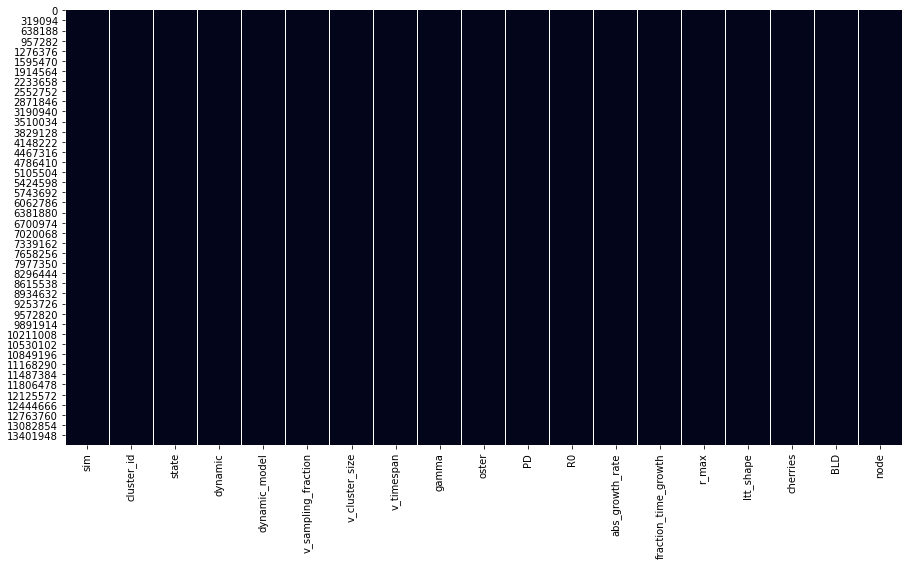

In [23]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(node_df.isnull(), cbar=False)
# FRom this heatmap too it is evident that the above 2 mentioned vars have more missing values

<AxesSubplot:>

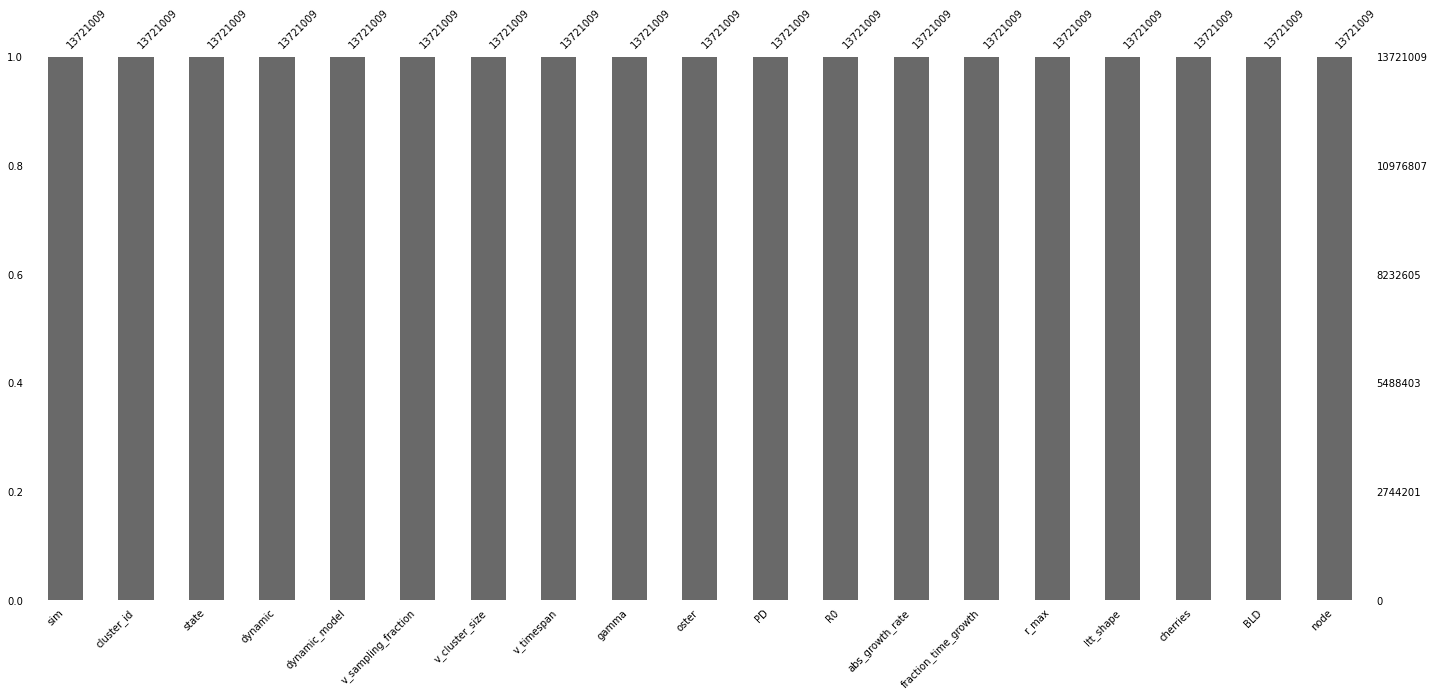

In [24]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(node_df,labels=True,fontsize=10) 

D:\Downloads\lib\site-packages\seaborn\matrix.py:311: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
D:\Downloads\lib\site-packages\seaborn\matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<AxesSubplot:>

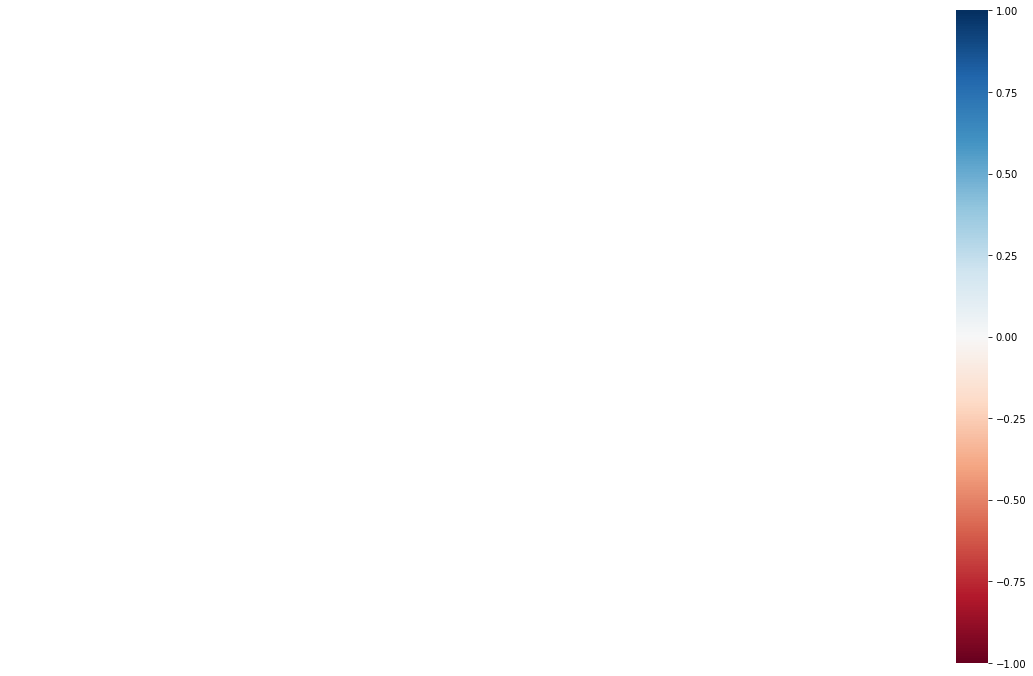

In [25]:
# The missingno correlation heatmap measures nullity correlation: 
# how strongly the presence or absence of one variable affects the presence of another:
msno.heatmap(node_df,labels=True) 

# Entries marked <1 or >-1 have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does)

### Preprocessing-2: edge data

In [22]:
edge_df.tail()

,from,to,weight1,weight2,sim
13712608,1396,231,12,0.009602,999
13712609,1396,575,12,0.009680,999
13712610,1393,1397,3,0.002858,999
13712611,1397,42,1,0.000948,999
13712612,1397,607,17,0.015876,999


In [23]:
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13712613 entries, 0 to 13712612
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   from     int64  
 1   to       int64  
 2   weight1  int64  
 3   weight2  float64
 4   sim      int64  
dtypes: float64(1), int64(4)
memory usage: 523.1 MB


### Count number of trees

In [24]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
#assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 9685


In [25]:
print('Shape of node data is', node_df.shape)
print('Shape of edge data is', edge_df.shape)

Shape of node data is (13721009, 19)
Shape of edge data is (13712613, 5)


### Extra: Error check duplicate number of nodes and edges on a tree
    Number of nodes for one tree should equal to number of edges plus 1. 

In [26]:
err_dic = {}
err_treeids = []
for one_tree_id in node_tree_ids:
    onetree_node_df = node_df[node_df['sim'] == one_tree_id] 
    uni_node_sample = onetree_node_df.drop_duplicates()
    uni_node = onetree_node_df.drop_duplicates('node')
    onetree_edge_df = edge_df[edge_df['sim'] == one_tree_id]
    uni_edge_sample = onetree_edge_df.drop_duplicates()
    uni_edge = onetree_edge_df.drop_duplicates(['from','to'])
    if len(uni_node) == len(uni_edge)+1:
        continue
    else:
        err_dic[one_tree_id] = [len(onetree_node_df),len(uni_node_sample),len(uni_node),len(onetree_edge_df),len(uni_edge_sample),len(uni_edge)]
        err_treeids.append(one_tree_id)
        node_df = node_df.drop(node_df[node_df['sim']==one_tree_id].index)
        edge_df = edge_df.drop(edge_df[edge_df['sim']==one_tree_id].index)

In [27]:
print('Shape of node data is', node_df.shape)
print('Shape of edge data is', edge_df.shape)

Shape of node data is (13721009, 19)
Shape of edge data is (13712613, 5)


In [28]:
for id in edge_tree_ids:
    if id in node_tree_ids:
        continue
    else:
        print(id)

2


In [29]:
edge_df[edge_df['sim']==2]

,from,to,weight1,weight2,sim
8327565,668,669,6,0.005062,2
8327566,669,670,11,0.009525,2
8327567,670,671,5,0.004300,2
8327568,671,672,3,0.002828,2
8327569,672,673,5,0.004389,2
...,...,...,...,...,...
8328849,1289,571,11,0.010801,2
8328850,1289,585,11,0.010517,2
8328851,1286,1290,19,0.018272,2
8328852,1290,86,10,0.008464,2


In [30]:
edge_df = edge_df.drop(edge_df[edge_df['sim']==2].index)

In [31]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 9685


In [32]:
print('Shape of node data is', node_df.shape)
print('Shape of edge data is', edge_df.shape)

Shape of node data is (13721009, 19)
Shape of edge data is (13711324, 5)


### Preprocessing-3: Gamma discretization
    * Quantile-based discretization function

In [33]:
gamma_cats, gamma_bins = pd.qcut(node_df['gamma'], 4, retbins=True, duplicates='drop')
gamma_cat_dict = {cat: i for i, cat in enumerate(gamma_cats.unique())}
print(gamma_bins)
print(gamma_cat_dict)

[-4391.2751509    -16.90331438   -15.71956291   -12.72151311
            inf]
{Interval(-16.903, -15.72, closed='right'): 0, Interval(-12.722, inf, closed='right'): 1, Interval(-15.72, -12.722, closed='right'): 2, Interval(-4391.276, -16.903, closed='right'): 3}


In [34]:
node_df['gamma_bin'] = gamma_cats
node_df['gamma_cat'] = node_df['gamma_bin'].replace(gamma_cat_dict, inplace=False)
print(f'Gamma cat: {node_df["gamma_cat"].unique()}')
node_df.head()

Gamma cat: [0 1 2 3]


,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat
0,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,1.0,"(-16.903, -15.72]",0
1,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,342.0,"(-16.903, -15.72]",0
2,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,488.0,"(-16.903, -15.72]",0
3,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,659.0,"(-16.903, -15.72]",0
4,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,95.0,"(-16.903, -15.72]",0


### Preprocessing-4: Encode the categorical feature and label
#### Categorical features
    * ltt_shape
    * gamma (processed before)

In [35]:
# Use to record all the feature transformations
feat_dict = dict()

In [36]:
node_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat
0,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,1.0,"(-16.903, -15.72]",0
1,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,342.0,"(-16.903, -15.72]",0
2,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,488.0,"(-16.903, -15.72]",0
3,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,659.0,"(-16.903, -15.72]",0
4,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,95.0,"(-16.903, -15.72]",0


In [37]:
#First of all we need to get the columns where the categorical features are present
# idea is to extract all the columns with type as object
node_df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64'),
       CategoricalDtype(categories=[(-4391.276, -16.903], (-16.903, -15.72], (-15.72, -12.722], (-12.722, inf]],
              ordered=True)], dtype=object)

In [38]:
for types in node_df.dtypes.unique():
    print(types,len(node_df.select_dtypes(types).columns))
    print(node_df.select_dtypes(types).columns)
    print('===')

int64 2
Index(['sim', 'gamma_cat'], dtype='object')
===
object 4
Index(['cluster_id', 'state', 'dynamic', 'ltt_shape'], dtype='object')
===
float64 14
Index(['dynamic_model', 'v_sampling_fraction', 'v_cluster_size', 'v_timespan',
       'gamma', 'oster', 'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth',
       'r_max', 'cherries', 'BLD', 'node'],
      dtype='object')
===
category 1
Index(['gamma_bin'], dtype='object')
===


In [39]:
# Category the ltt_shape

# node_df = node_df.astype({'ltt_shape': 'category'}, copy=False)
node_df["ltt_shape"] = node_df["ltt_shape"].astype('category')
node_df["ltt_shape_cat"] = node_df["ltt_shape"].cat.codes
feat_dict['ltt_shape'] = dict(enumerate(node_df['ltt_shape'].cat.categories))
      
print(feat_dict)
node_df.head()

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}}


,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat
0,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,1.0,"(-16.903, -15.72]",0,0
1,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,342.0,"(-16.903, -15.72]",0,0
2,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,488.0,"(-16.903, -15.72]",0,0
3,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,659.0,"(-16.903, -15.72]",0,0
4,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,95.0,"(-16.903, -15.72]",0,0


In [40]:
# Record the cat_dict for gamma, reverse the previous the dict
for feat_name, cat_dict in zip(['gamma'], [gamma_cat_dict]):
    tmp_dict = {}
    for k, v in cat_dict.items():
        tmp_dict[v] = f'{k.left, k.right, k.closed}'
    feat_dict[feat_name] = tmp_dict
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-16.903, -15.72, 'right')", 1: "(-12.722, inf, 'right')", 2: "(-15.72, -12.722, 'right')", 3: "(-4391.276, -16.903, 'right')"}}


#### Categorical label
    * Convert the dynamic column to the int value
    * 0 for background

In [41]:
node_df["dynamic"] = node_df["dynamic"].astype('category')
node_df["dynamic_cat"] = node_df["dynamic"].cat.codes

In [42]:
node_df

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
0,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,1.0,"(-16.903, -15.72]",0,0,0
1,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,342.0,"(-16.903, -15.72]",0,0,0
2,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,488.0,"(-16.903, -15.72]",0,0,0
3,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,659.0,"(-16.903, -15.72]",0,0,0
4,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,95.0,"(-16.903, -15.72]",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13721004,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.500000,1.404546,convex,0.375000,-1.0,615.0,"(-12.722, inf]",1,2,3
13721005,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.500000,1.404546,convex,0.375000,-1.0,1033.0,"(-12.722, inf]",1,2,3
13721006,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.500000,1.404546,convex,0.375000,-1.0,676.0,"(-12.722, inf]",1,2,3
13721007,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.500000,1.404546,convex,0.375000,-1.0,1036.0,"(-12.722, inf]",1,2,3


In [43]:
node_df = node_df.reset_index(drop=True)
impute_node = np.where(node_df['state']=='Background')
node_df.loc[(impute_node[0]),'dynamic_cat']=3
impute_node = np.where(node_df['dynamic']=='static')
node_df.loc[(impute_node[0]),'dynamic_cat']=0
feat_dict['dynamic'] = dict(enumerate(node_df['dynamic'].cat.categories))
feat_dict['dynamic'][0] = 'static'
feat_dict['dynamic'][3] = 'bg'
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-16.903, -15.72, 'right')", 1: "(-12.722, inf, 'right')", 2: "(-15.72, -12.722, 'right')", 3: "(-4391.276, -16.903, 'right')"}, 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}}


In [44]:
node_df.tail()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
13721004,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,615.0,"(-12.722, inf]",1,2,0
13721005,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1033.0,"(-12.722, inf]",1,2,0
13721006,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,676.0,"(-12.722, inf]",1,2,0
13721007,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1036.0,"(-12.722, inf]",1,2,0
13721008,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.05303,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375,-1.0,1034.0,"(-12.722, inf]",1,2,0


### Add state ID for post analysis

In [45]:
group_dict = {}
i = 0
for group in ['Background','A','B','C','D','E','F','G']:
    group_dict[group] = i
    i += 1
group_dict

{'Background': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

In [46]:
node_df['state_id'] = node_df['state'].apply(lambda x: group_dict[x])

### Split the nodes into background and non-background

In [47]:
background_df = node_df[node_df['cluster_id']=='Background']
background_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id
0,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,1.0,"(-16.903, -15.72]",0,0,3,0
1,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,342.0,"(-16.903, -15.72]",0,0,3,0
2,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,488.0,"(-16.903, -15.72]",0,0,3,0
3,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,659.0,"(-16.903, -15.72]",0,0,3,0
4,10000,Background,Background,bg,0.0,0.053017,536.0,84.0,-16.313491,104.004008,13536.0,-5.093836,327.307131,0.208333,11005.218898,concave,0.331492,6.0,95.0,"(-16.903, -15.72]",0,0,3,0


In [48]:
node_df = node_df[node_df['cluster_id']!='Background']
node_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id
1055,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,68.0,"(-12.722, inf]",1,0,0,1
1056,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,429.0,"(-12.722, inf]",1,0,0,1
1057,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,969.0,"(-12.722, inf]",1,0,0,1
1058,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,968.0,"(-12.722, inf]",1,0,0,1
1059,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,476.0,"(-12.722, inf]",1,0,0,1


### Analysis-1 Correlation 
#### 1-1. The relationship between categorical features and label

In [49]:
from sklearn.feature_selection import chi2, mutual_info_classif

cat_feat_cols = ['ltt_shape_cat', 'gamma_cat']
chi2_sts, p_vals = chi2(node_df[cat_feat_cols], node_df['dynamic_cat'])
mis = mutual_info_classif(node_df[cat_feat_cols], node_df['dynamic_cat'])

for cat, chi2, p_val, mi in zip(cat_feat_cols, chi2_sts, p_vals, mis):
    degree_freedom = (len(node_df['dynamic_cat'].unique()) - 1) * (len(node_df[cat].unique())-1)
    print(f'{cat}: \n  df: {degree_freedom}, chi2: {chi2}, p_vals: {p_val}\n  MI: {mi}')

ltt_shape_cat: 
  df: 6, chi2: 15055.450282156975, p_vals: 0.0
  MI: 0.09619877337333427
gamma_cat: 
  df: 6, chi2: 258.6704620691543, p_vals: 6.76741556633494e-57
  MI: 0.20954776563595345


### Analysis-1
#### 1-2 The relationship between numerical features and label

In [50]:
num_feat_cols = ["v_sampling_fraction", "v_cluster_size", "v_timespan", "oster", "PD",
                 "abs_growth_rate", "fraction_time_growth", "r_max","cherries","BLD","R0"]
aly_col = num_feat_cols + cat_feat_cols
print(aly_col)

aly_df = node_df[aly_col]
print(aly_df.shape, f"num_feat: {len(num_feat_cols)}, cat_feat: {len(cat_feat_cols)}")

['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'R0', 'ltt_shape_cat', 'gamma_cat']
(1901456, 13) num_feat: 11, cat_feat: 2


#### 1-2-1 Pearson R

In [51]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_df.corr()

,v_sampling_fraction,v_cluster_size,v_timespan,oster,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,R0,ltt_shape_cat,gamma_cat
v_sampling_fraction,1.000000,-0.575386,-0.227616,-0.223483,-0.344420,0.001592,0.045020,0.000815,-0.069894,-0.094538,0.002212,0.051000,0.012580
v_cluster_size,-0.575386,1.000000,0.534965,0.528902,0.720034,-0.002706,0.000035,0.010141,0.051833,0.193545,0.007310,-0.159110,0.031354
v_timespan,-0.227616,0.534965,1.000000,0.976293,0.875314,-0.002195,0.067690,0.025005,0.042585,0.406880,0.017047,-0.251774,0.135064
oster,-0.223483,0.528902,0.976293,1.000000,0.870701,-0.001975,0.055683,0.025259,0.026416,0.408681,0.017052,-0.258079,0.171971
PD,-0.344420,0.720034,0.875314,0.870701,1.000000,-0.003454,0.050218,0.016848,0.062266,0.380748,0.012323,-0.302729,0.105945
abs_growth_rate,0.001592,-0.002706,-0.002195,-0.001975,-0.003454,1.000000,-0.005096,0.000058,-0.004966,0.001613,0.000048,0.001493,-0.000856
fraction_time_growth,0.045020,0.000035,0.067690,0.055683,0.050218,-0.005096,1.000000,0.020878,0.016767,-0.004383,0.014901,-0.041293,0.011960
r_max,0.000815,0.010141,0.025005,0.025259,0.016848,0.000058,0.020878,1.000000,0.014320,0.024949,0.938497,-0.005865,0.003583
cherries,-0.069894,0.051833,0.042585,0.026416,0.062266,-0.004966,0.016767,0.014320,1.000000,0.066514,0.015057,-0.018179,-0.046543
BLD,-0.094538,0.193545,0.406880,0.408681,0.380748,0.001613,-0.004383,0.024949,0.066514,1.000000,0.014143,-0.166218,0.045205


In [52]:
Paper_feat = ['Sampling Fraction', 'Cluster Size', 'Time Span', 'Oster', 'PD', 'Abs Growth Rate','Fraction Time Growth',r'$R_{max}$','Cherries','BLD',r'$R_0$', 'LTT Shape',r'$\gamma$']

[Text(0, 0.5, 'Sampling Fraction'),
 Text(0, 1.5, 'Cluster Size'),
 Text(0, 2.5, 'Time Span'),
 Text(0, 3.5, 'Oster'),
 Text(0, 4.5, 'PD'),
 Text(0, 5.5, 'Abs Growth Rate'),
 Text(0, 6.5, 'Fraction Time Growth'),
 Text(0, 7.5, '$R_{max}$'),
 Text(0, 8.5, 'Cherries'),
 Text(0, 9.5, 'BLD'),
 Text(0, 10.5, '$R_0$'),
 Text(0, 11.5, 'LTT Shape'),
 Text(0, 12.5, '$\\gamma$')]

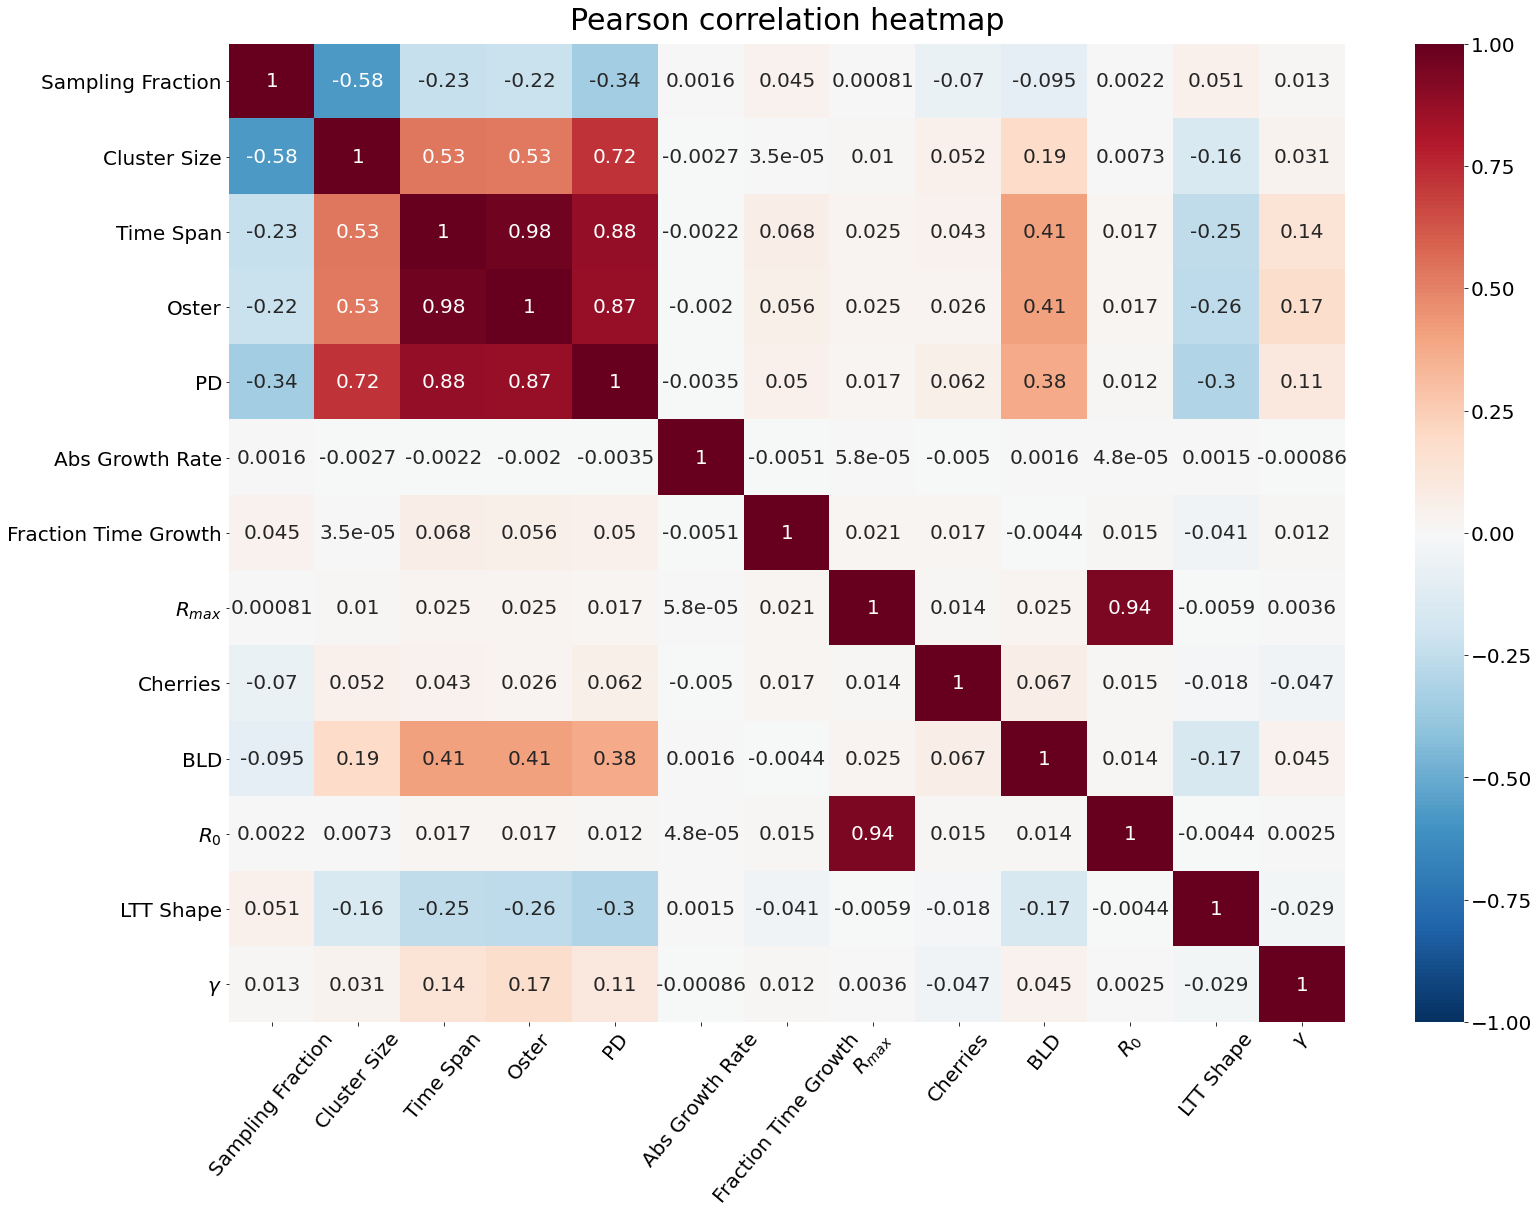

In [53]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
fig = plt.figure(figsize=(25, 18))
plt.rcParams.update({'font.size': 20})
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr(), vmin=-1, vmax=1, annot=True,cmap='RdBu_r')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Pearson correlation heatmap', fontdict={'fontsize':30}, pad=14);
heatmap.set_xticklabels(Paper_feat,rotation=50)
heatmap.set_yticklabels(Paper_feat)
#fig.savefig('../paper/pearson.svg',dpi=600,format='svg',bbox_inches='tight',pad_inches=0.0)

#### 1-2-2 Spearman correlation

In [54]:
# Compute pairwise correlation of columns (Spearman rank correlation, non-linear)
aly_df.corr("spearman")

,v_sampling_fraction,v_cluster_size,v_timespan,oster,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,R0,ltt_shape_cat,gamma_cat
v_sampling_fraction,1.000000,-0.463016,-0.184137,-0.184431,-0.224923,-0.165379,0.037890,-0.179783,-0.086128,-0.193458,0.031067,0.040820,0.011404
v_cluster_size,-0.463016,1.000000,0.639707,0.632392,0.697742,0.340363,0.060162,0.547886,0.039402,0.288462,0.115263,-0.210514,0.068029
v_timespan,-0.184137,0.639707,1.000000,0.981047,0.929144,0.389793,0.110537,0.769687,0.013684,0.362971,0.163931,-0.268229,0.128259
oster,-0.184431,0.632392,0.981047,1.000000,0.927864,0.441101,0.098308,0.807089,-0.002813,0.374437,0.110613,-0.272628,0.157858
PD,-0.224923,0.697742,0.929144,0.927864,1.000000,0.472794,0.110979,0.793340,0.035132,0.451656,0.164851,-0.333737,0.119670
abs_growth_rate,-0.165379,0.340363,0.389793,0.441101,0.472794,1.000000,-0.211640,0.684069,0.001190,0.362473,-0.423411,-0.139745,0.102823
fraction_time_growth,0.037890,0.060162,0.110537,0.098308,0.110979,-0.211640,1.000000,0.132235,0.007021,-0.039081,0.357393,-0.058114,0.019164
r_max,-0.179783,0.547886,0.769687,0.807089,0.793340,0.684069,0.132235,1.000000,0.004479,0.355168,-0.054144,-0.247933,0.156151
cherries,-0.086128,0.039402,0.013684,-0.002813,0.035132,0.001190,0.007021,0.004479,1.000000,0.067705,0.018880,-0.008669,-0.056363
BLD,-0.193458,0.288462,0.362971,0.374437,0.451656,0.362473,-0.039081,0.355168,0.067705,1.000000,-0.016904,-0.152628,0.001019


[Text(0, 0.5, 'Sampling Fraction'),
 Text(0, 1.5, 'Cluster Size'),
 Text(0, 2.5, 'Time Span'),
 Text(0, 3.5, 'Oster'),
 Text(0, 4.5, 'PD'),
 Text(0, 5.5, 'Abs Growth Rate'),
 Text(0, 6.5, 'Fraction Time Growth'),
 Text(0, 7.5, '$R_{max}$'),
 Text(0, 8.5, 'Cherries'),
 Text(0, 9.5, 'BLD'),
 Text(0, 10.5, '$R_0$'),
 Text(0, 11.5, 'LTT Shape'),
 Text(0, 12.5, '$\\gamma$')]

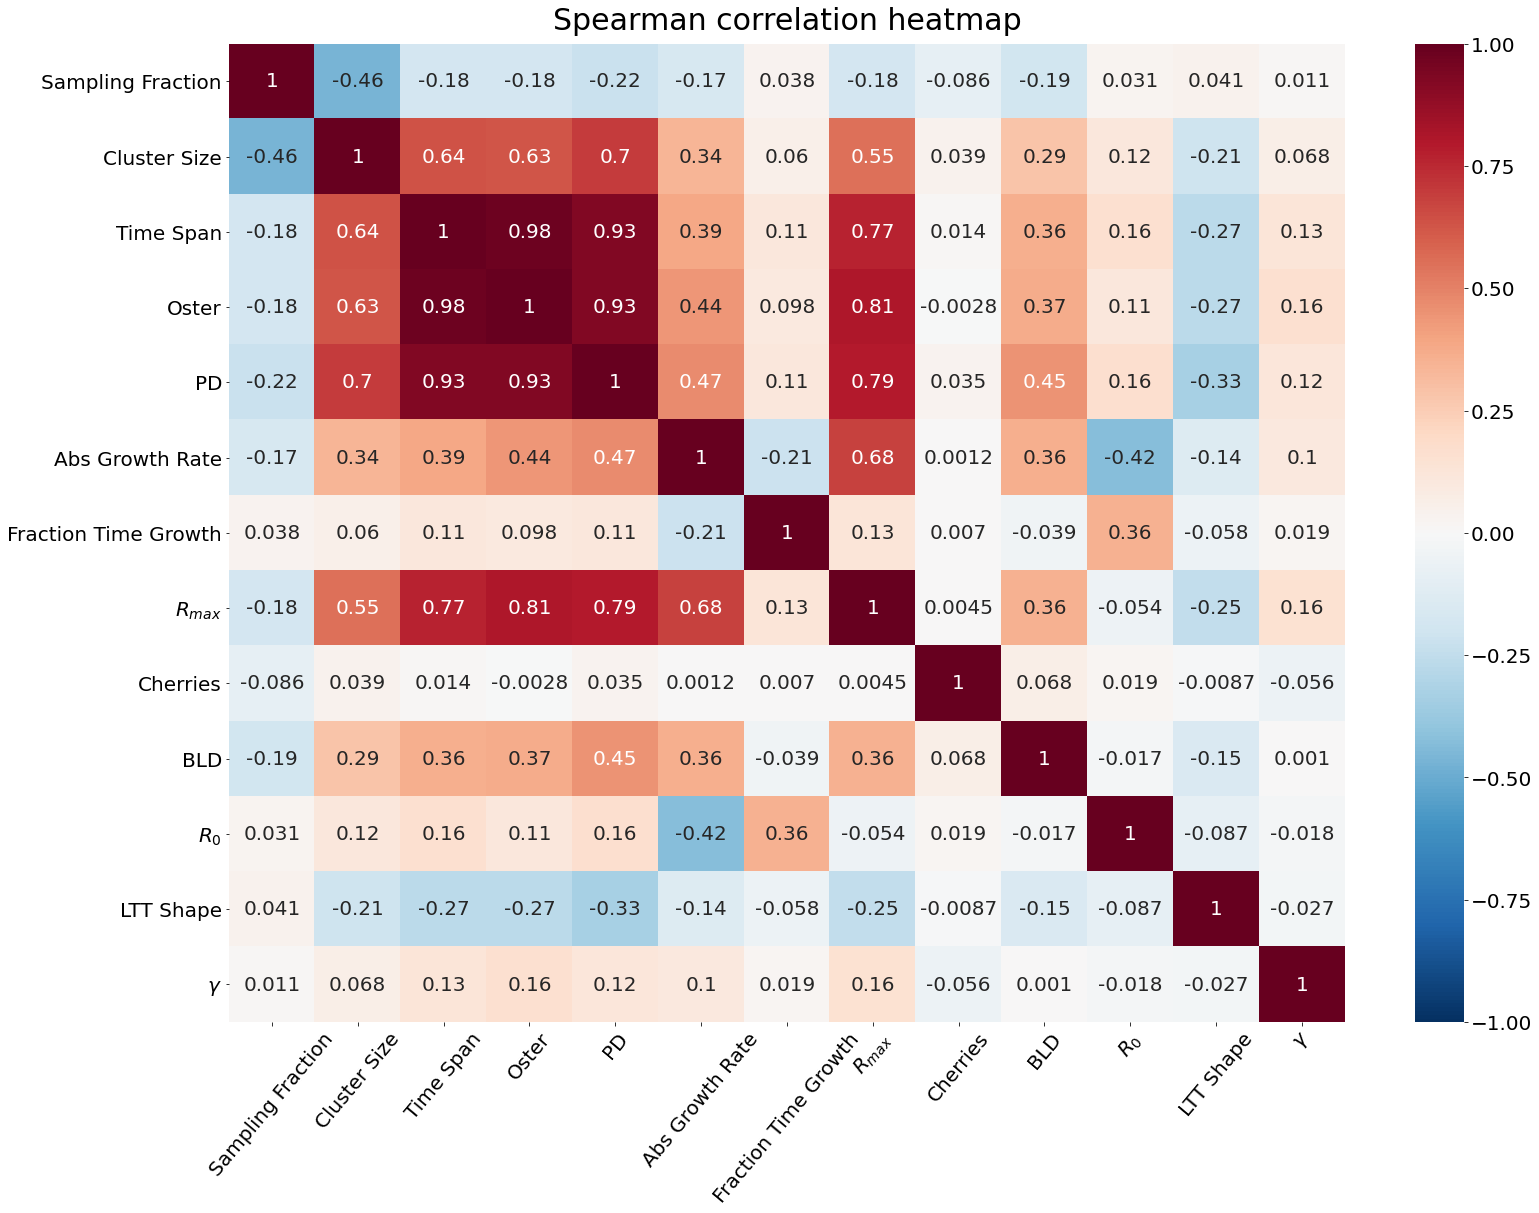

In [55]:
# Correlation Matrix

# Increase the size of the heatmap.
fig = plt.figure(figsize=(25, 18))
plt.rcParams.update({'font.size': 20})
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr('spearman'), vmin=-1, vmax=1, annot=True,cmap='RdBu_r')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Spearman correlation heatmap', fontdict={'fontsize':30}, pad=14);
heatmap.set_xticklabels(Paper_feat,rotation=50)
heatmap.set_yticklabels(Paper_feat)
#fig.savefig('../paper/spearman.svg',dpi=600,format='svg',bbox_inches='tight',pad_inches=0.0)

## Processing for Modeling

### Processing-1. One-hot encoding for the categorical feature
* ltt_shape_cat
* gamma_cat

In [56]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

cat_feat_cols = list(set(cat_feat_cols)) # ['ltt_shape_cat','gamma_cat']
print(cat_feat_cols)
cat_onehot_feat = []
org_idx = node_df.index

for cat_feat in cat_feat_cols:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    x = enc.fit_transform(node_df[cat_feat].values.reshape(-1, 1))
    n_dims = x.shape[-1]
    columns = [f'{cat_feat}_{i}' for i in range(n_dims)]
    cat_onehot_feat += columns
    cat_df = pd.DataFrame(x, index=org_idx, columns=columns)
    node_df = pd.concat([node_df, cat_df], axis=1)

['ltt_shape_cat', 'gamma_cat']


In [57]:
node_df

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
1055,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,68.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1056,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,429.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1057,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,969.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1058,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,968.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1059,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,476.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13721004,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375000,-1.0,615.0,"(-12.722, inf]",1,2,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
13721005,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375000,-1.0,1033.0,"(-12.722, inf]",1,2,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
13721006,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375000,-1.0,676.0,"(-12.722, inf]",1,2,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
13721007,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375000,-1.0,1036.0,"(-12.722, inf]",1,2,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Split the train/test sets (should put before imputing the missing values and calculating the correlation)

In [58]:
random_seed = 123
np.random.seed(random_seed)
split_dir = f'../data/preprocessed_data/split_rs{random_seed}'
os.makedirs(split_dir, exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 7748, Test: 1937
[18905 13921 15041  2500  4130  6861  8934  5555  6858  8026]


In [59]:
train_background_df = background_df[background_df['sim'].isin(train_ids)]
test_background_df = background_df[background_df['sim'].isin(test_ids)]
train_node_df = node_df[node_df['sim'].isin(train_ids)]
test_node_df = node_df[node_df['sim'].isin(test_ids)]

print(f'Train: {train_background_df.shape[0] + train_node_df.shape[0]}')
print(f'Test: {test_background_df.shape[0] + test_node_df.shape[0]}')
train_node_df.head()

Train: 10981509
Test: 2739500


,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
1055,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,68.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1056,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,429.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1057,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,969.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1058,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,968.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1059,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,476.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Processing-2: R0 correction
* Use the mean value of positive R0 in the **training** to replace all the negative R0 in the training and test
* Normalize the R0

In [60]:
raw_r0 = np.reshape(train_node_df['R0'].values, (-1, 1))

# negtive replacement
r0_neg_idx = raw_r0 <= 0
r0_pos_idx = raw_r0 > 0
avg_r0 = np.average(raw_r0[r0_pos_idx])

raw_r0[r0_neg_idx] = avg_r0

In [61]:
train_node_df['R0'].describe()

count    1.521224e+06
mean     1.880223e+00
std      7.932662e-01
min      2.428706e-04
25%      1.880223e+00
50%      1.880223e+00
75%      1.880223e+00
max      8.804884e+00
Name: R0, dtype: float64

In [62]:
r0_norm_col = 'new_R0'
train_node_df[r0_norm_col]=raw_r0
train_node_df[r0_norm_col].describe()

<ipython-input-62-b22872fa3f62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_node_df[r0_norm_col]=raw_r0


count    1.521224e+06
mean     1.880223e+00
std      7.932662e-01
min      2.428706e-04
25%      1.880223e+00
50%      1.880223e+00
75%      1.880223e+00
max      8.804884e+00
Name: new_R0, dtype: float64

In [63]:
test_node_df['R0'].describe()

count    3.802320e+05
mean    -3.746887e+04
std      3.138976e+06
min     -4.834442e+08
25%     -9.536458e+00
50%     -2.211436e-01
75%      1.654331e+00
max      8.569507e+00
Name: R0, dtype: float64

In [64]:
raw_r0 = np.reshape(test_node_df['R0'].values, (-1, 1))
r0_neg_idx = raw_r0 <= 0
raw_r0[r0_neg_idx] = avg_r0

In [65]:
r0_norm_col = 'new_R0'
test_node_df[r0_norm_col]=raw_r0
test_node_df[r0_norm_col].describe()

<ipython-input-65-defbe93cbb89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_node_df[r0_norm_col]=raw_r0


count    380232.000000
mean          1.877235
std           0.818741
min           0.001790
25%           1.828241
50%           1.880223
75%           1.880223
max           8.569507
Name: new_R0, dtype: float64

In [66]:
num_feat_cols[-1] = 'new_R0'

### Processing-3. Normalize the input features:
* Use Standardization
* Use MinMax normalization to normalize data to [0, 1]

array([[<AxesSubplot:title={'center':'v_sampling_fraction'}>,
        <AxesSubplot:title={'center':'v_cluster_size'}>,
        <AxesSubplot:title={'center':'v_timespan'}>],
       [<AxesSubplot:title={'center':'oster'}>,
        <AxesSubplot:title={'center':'PD'}>,
        <AxesSubplot:title={'center':'abs_growth_rate'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth'}>,
        <AxesSubplot:title={'center':'r_max'}>,
        <AxesSubplot:title={'center':'cherries'}>],
       [<AxesSubplot:title={'center':'BLD'}>,
        <AxesSubplot:title={'center':'new_R0'}>, <AxesSubplot:>]],
      dtype=object)

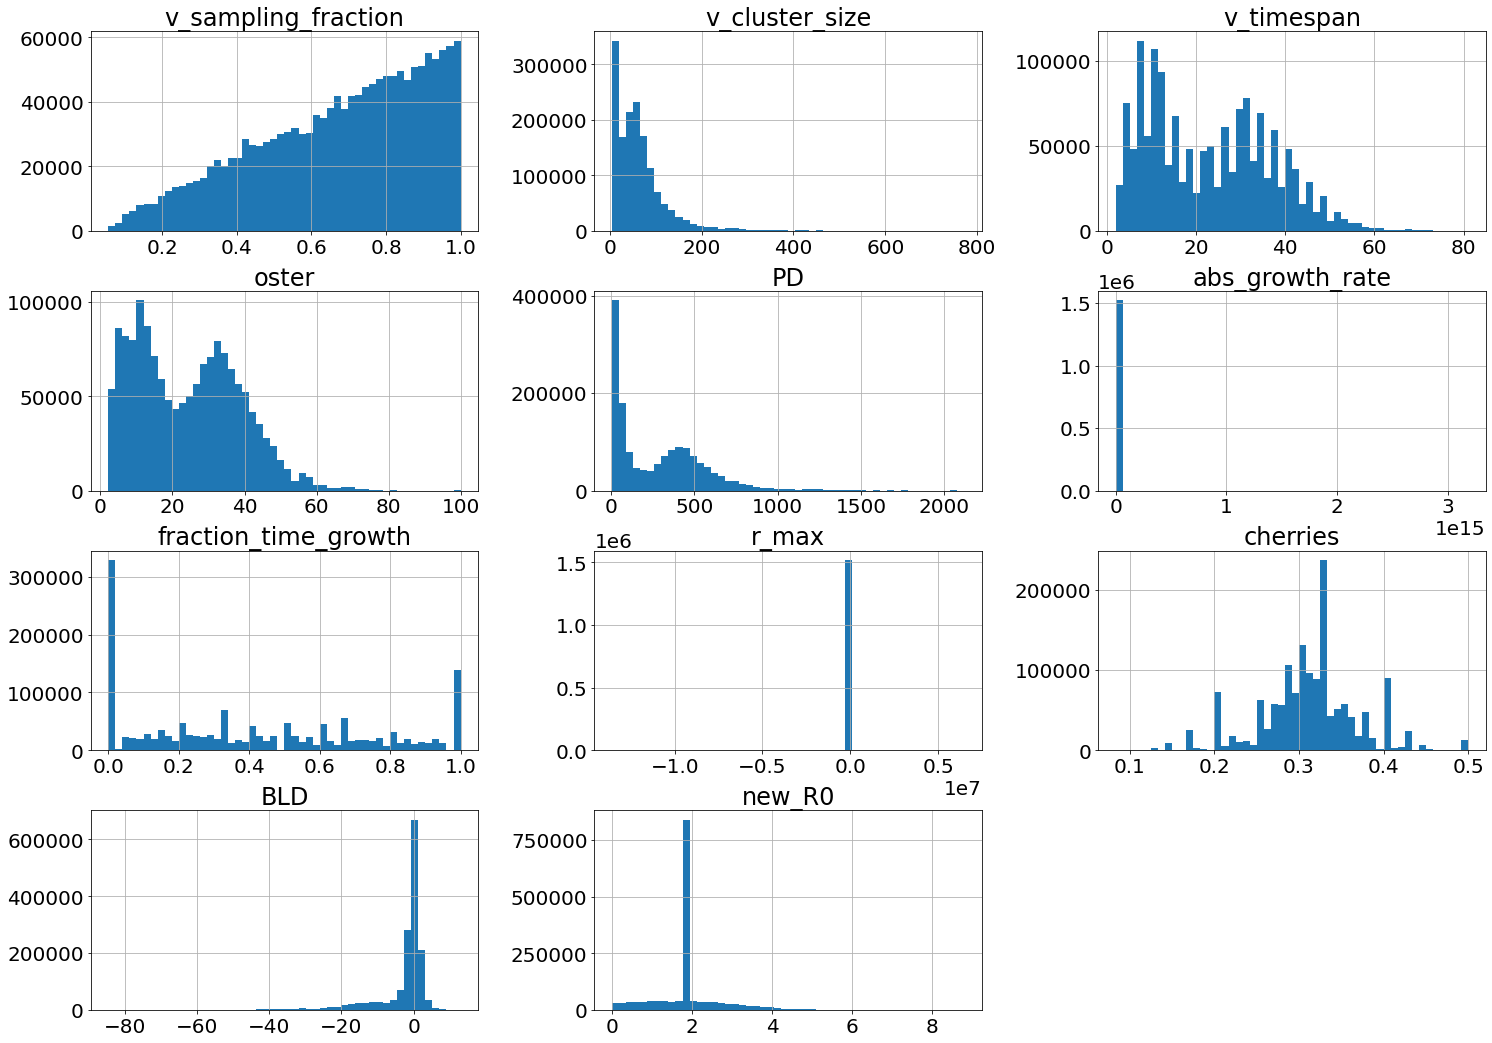

In [67]:
train_node_df[num_feat_cols].hist(bins=50,figsize=(25, 18))

In [68]:
num_feat_cols

['v_sampling_fraction',
 'v_cluster_size',
 'v_timespan',
 'oster',
 'PD',
 'abs_growth_rate',
 'fraction_time_growth',
 'r_max',
 'cherries',
 'BLD',
 'new_R0']

In [69]:
cat_feat_cols

['ltt_shape_cat', 'gamma_cat']

In [70]:
feat_cols = num_feat_cols+cat_feat_cols
feat_cols

['v_sampling_fraction',
 'v_cluster_size',
 'v_timespan',
 'oster',
 'PD',
 'abs_growth_rate',
 'fraction_time_growth',
 'r_max',
 'cherries',
 'BLD',
 'new_R0',
 'ltt_shape_cat',
 'gamma_cat']

In [71]:
# Standardization non-category features
std_scaler = preprocessing.StandardScaler().fit(train_node_df[num_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in num_feat_cols]
norm_train_vals = std_scaler.transform(train_node_df[num_feat_cols])
norm_train_node_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_node_df.index)
train_node_df = pd.concat([train_node_df, norm_train_node_df], axis=1)

In [72]:
norm_train_vals

array([[ 0.81033055,  0.0644563 ,  0.71494798, ..., -0.55863805,
         0.05320241,  0.45862841],
       [ 0.81033055,  0.0644563 ,  0.71494798, ..., -0.55863805,
         0.05320241,  0.45862841],
       [ 0.81033055,  0.0644563 ,  0.71494798, ..., -0.55863805,
         0.05320241,  0.45862841],
       ...,
       [ 0.71847376, -0.915988  , -1.24679849, ...,  1.06650274,
         0.19543302, -2.25955911],
       [ 0.71847376, -0.915988  , -1.24679849, ...,  1.06650274,
         0.19543302, -2.25955911],
       [ 0.71847376, -0.915988  , -1.24679849, ...,  1.06650274,
         0.19543302, -2.25955911]])

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>],
       [<AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>, <AxesSubplot:>]],
      dtype=object)

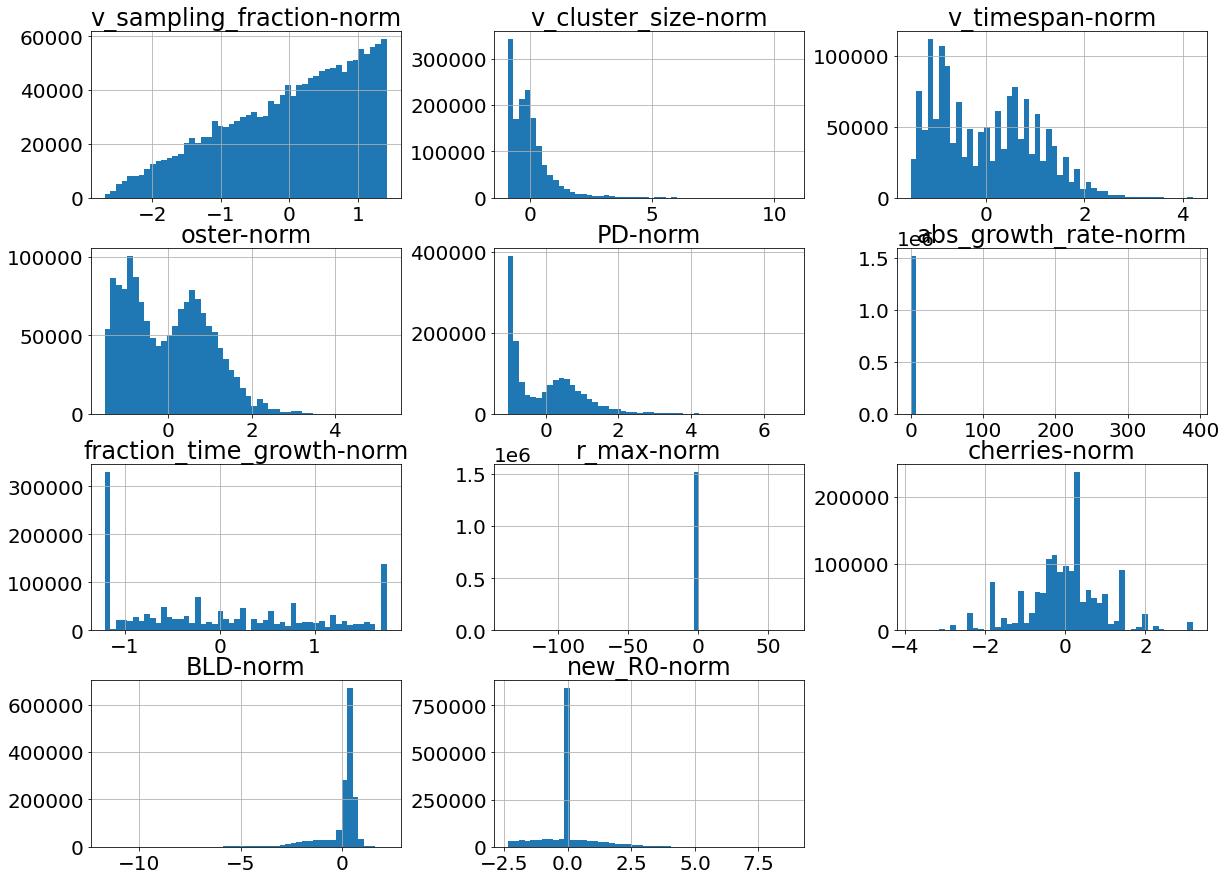

In [73]:
train_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [74]:
print(std_scaler.mean_, std_scaler.scale_)

[ 6.73778134e-01  6.67267746e+01  2.31599948e+01  2.42680239e+01
  2.90140860e+02  3.84601301e+10  4.07582633e-01 -2.48455915e+03
  3.11795351e-01 -2.37405734e+00  1.88022286e+00] [2.29784066e-01 6.62964737e+01 1.37632464e+01 1.44296808e+01
 2.72191387e+02 8.17208241e+12 3.37078141e-01 9.95363335e+04
 5.92634656e-02 7.03083502e+00 7.93265923e-01]


In [75]:
norm_test_vals = std_scaler.transform(test_node_df[num_feat_cols])
norm_test_node_df = pd.DataFrame(norm_test_vals, columns=norm_num_feat_cols, index=test_node_df.index)
test_node_df = pd.concat([test_node_df, norm_test_node_df], axis=1)

array([[<AxesSubplot:title={'center':'v_sampling_fraction-norm'}>,
        <AxesSubplot:title={'center':'v_cluster_size-norm'}>,
        <AxesSubplot:title={'center':'v_timespan-norm'}>],
       [<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>],
       [<AxesSubplot:title={'center':'fraction_time_growth-norm'}>,
        <AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>],
       [<AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>, <AxesSubplot:>]],
      dtype=object)

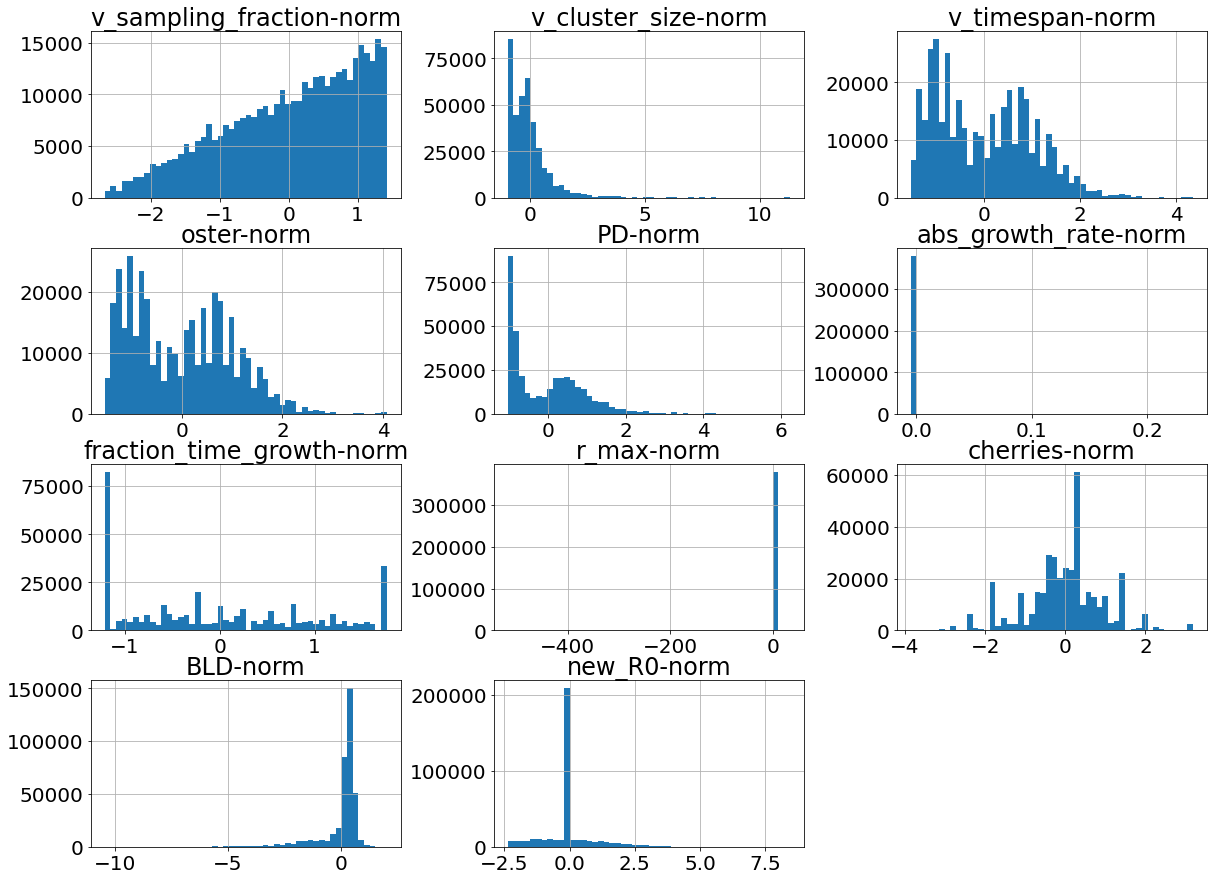

In [76]:
test_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [77]:
train_node_df

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
1055,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,68.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1056,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,429.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1057,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,969.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1058,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,968.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1059,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,476.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13721004,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375000,-1.0,615.0,"(-12.722, inf]",1,2,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.087792,0.718474,-0.915988,-1.246798,-1.262328,-0.992467,-0.004706,0.274172,0.024975,1.066503,0.195433,-2.259559
13721005,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375000,-1.0,1033.0,"(-12.722, inf]",1,2,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.087792,0.718474,-0.915988,-1.246798,-1.262328,-0.992467,-0.004706,0.274172,0.024975,1.066503,0.195433,-2.259559
13721006,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375000,-1.0,676.0,"(-12.722, inf]",1,2,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.087792,0.718474,-0.915988,-1.246798,-1.262328,-0.992467,-0.004706,0.274172,0.024975,1.066503,0.195433,-2.259559
13721007,999,c5,D,static,0.0,0.838872,6.0,6.0,1.838478,6.053030,20.0,0.087792,0.702273,0.5,1.404546,convex,0.375000,-1.0,1036.0,"(-12.722, inf]",1,2,0,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.087792,0.718474,-0.915988,-1.246798,-1.262328,-0.992467,-0.004706,0.274172,0.024975,1.066503,0.195433,-2.259559


#### Plot for Paper Supplementary(not included in preprocessing) 

remove samples with AbsGrowth Rate>100
train_node_df = train_node_df[train_node_df[feat_cols[5]]<100]
test_node_df = test_node_df[test_node_df[feat_cols[5]]<100]

D:\Downloads\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


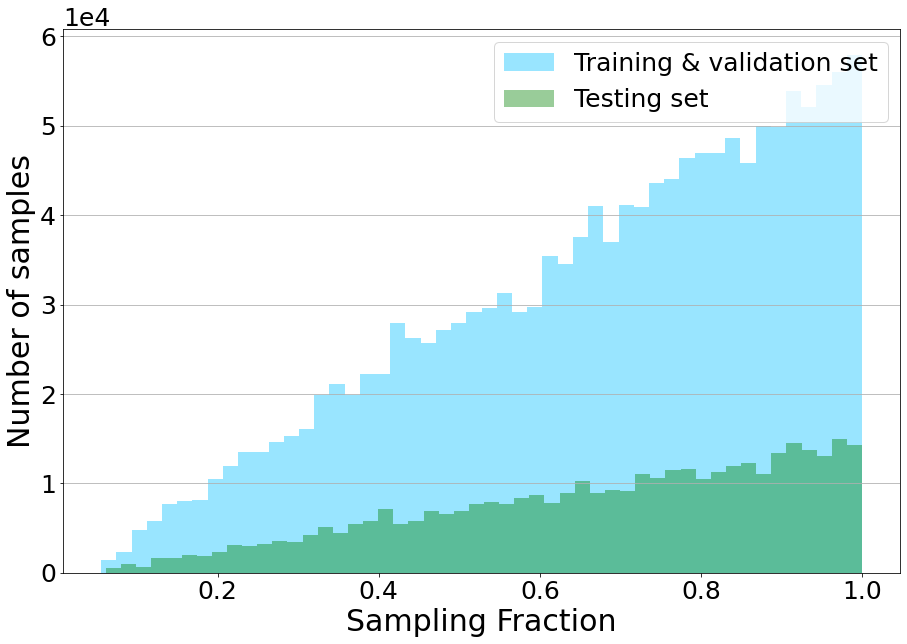

In [90]:
i = 0
feat = feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,700000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
#ax1.axes.set_xlabel(f"{Paper_feat[i]} category",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

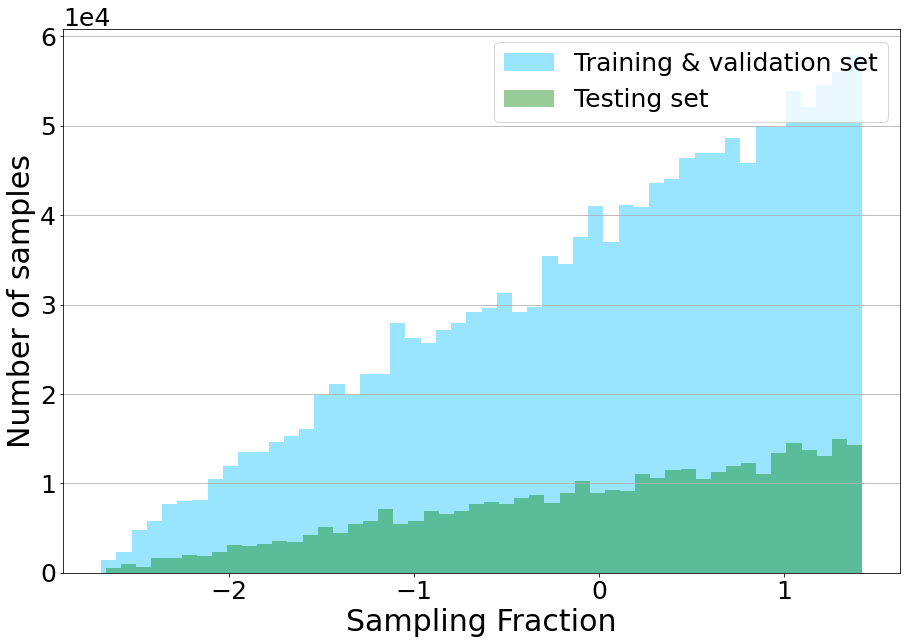

In [91]:
i = 0
feat = norm_num_feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,1800000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/norm_feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

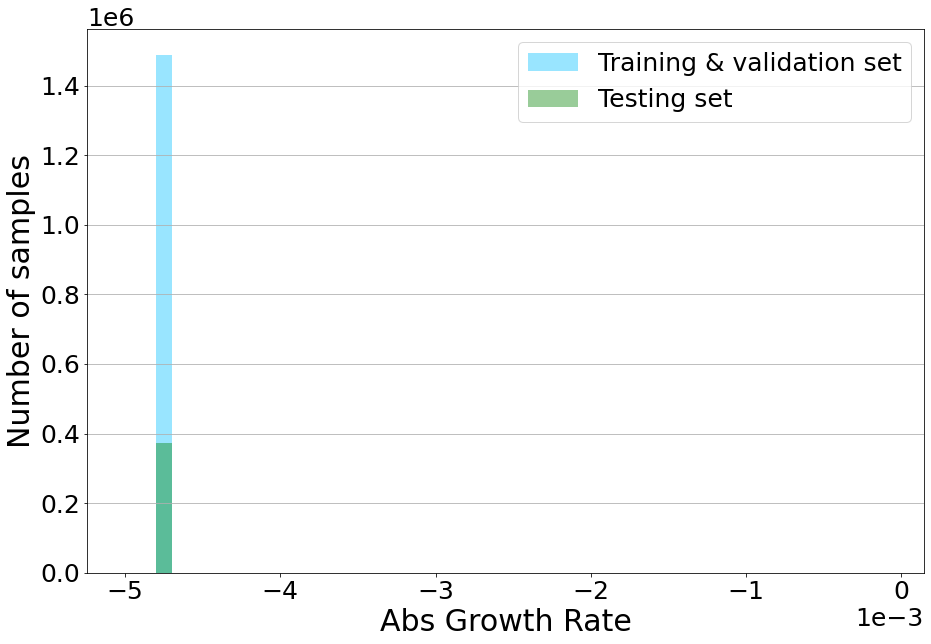

In [92]:
# special for AbsGrowthRate
i = 5
feat = norm_num_feat_cols[i]
#for feat in feat_cols:
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_node_df[feat],bins=np.arange(-0.005,0,0.0001),hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_node_df[feat],bins=np.arange(-0.005,0,0.0001),hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,1800000))
ax1.axes.set_ylabel("Number of samples",fontsize=30)
ax1.axes.set_xlabel(f"{Paper_feat[i]}",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/norm_feat_dist/{feat}.svg",bbox_inches='tight',pad_inches=0.0,dpi=600,format='svg')

### Obtain the onehot features

In [78]:
import re
all_cols = node_df.columns.values

onehot_cols = []
for feat_name, pattern in zip(['ltt_shape_onehot', 'R0_onehot', 'gamma_onehot'], 
                              ['ltt_shape_cat_\d*', 'R0_cat_\d*', 'gamma_cat_\d']):
    for feat_col in all_cols:
        m = re.match(pattern, feat_col)
        if m:
            feat_dict.setdefault(feat_name, []).append(m.group(0))
            
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'gamma': {0: "(-16.903, -15.72, 'right')", 1: "(-12.722, inf, 'right')", 2: "(-15.72, -12.722, 'right')", 3: "(-4391.276, -16.903, 'right')"}, 'dynamic': {0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}, 'ltt_shape_onehot': ['ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3'], 'gamma_onehot': ['gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']}


In [79]:
print(train_node_df.shape)

(1521224, 44)


In [80]:
train_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
1055,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,68.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1056,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,429.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1057,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,969.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1058,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,968.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1059,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,476.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628


In [81]:
train_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
1055,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,68.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1056,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,429.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1057,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,969.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1058,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,968.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1059,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,476.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628


### Merge the background and non-background nodes

In [82]:
# train_full_df = train_node_df.merge(train_background_df, how='inner', left_on=list(train_background_df.columns), right_on=list(train_background_df.columns), left_index=True, right_index=True)
#train_full_df = train_node_df
#print(f'Train: {train_full_df.shape}')

#test_full_df = test_node_df
#print(f'Test: {test_full_df.shape}')

train_full_df = pd.concat([train_node_df, train_background_df])
print(f'Train: {train_full_df.shape}')

test_full_df = pd.concat([test_node_df, test_background_df])
print(f'Test: {test_full_df.shape}')

Train: (10981509, 44)
Test: (2739500, 44)


#### Split validation set

In [83]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Test: {len(valid_ids)}")
print(test_ids[:10])

Train: 5811, Test: 1937
[18905 13921 15041  2500  4130  6861  8934  5555  6858  8026]


In [84]:
train_full_df = train_full_df.reset_index(drop=True)
train_node_df = train_full_df[train_full_df['sim'].isin(train_ids)]
valid_node_df = train_full_df[train_full_df['sim'].isin(valid_ids)]

print(f'Train node: {train_node_df.shape[0]}')
print(f'Valid node: {valid_node_df.shape[0]}')
train_node_df.head()

Train node: 8228773
Valid node: 2752736


,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,68.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,429.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
2,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,969.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
3,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,968.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
4,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,476.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628


In [85]:
print(f'Test node: {test_full_df.shape[0]}')

Test node: 2739500


In [86]:
# Save the train/valid/test to the disk
train_node_df.to_csv(f'{split_dir}/train.csv', index=False)
test_full_df.to_csv(f'{split_dir}/test.csv', index=False)
valid_node_df.to_csv(f'{split_dir}/valid.csv', index=False)

In [87]:
train_full_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
0,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,68.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
1,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,429.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
2,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,969.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
3,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,968.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628
4,10000,c1,A,static,0.0,0.859979,71.0,33.0,-0.099931,33.009825,483.0,2.244037,5.193084,0.0,37.971435,concave,0.278689,-2.0,476.0,"(-12.722, inf]",1,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.244037,0.810331,0.064456,0.714948,0.605821,0.708542,-0.004706,-1.209164,0.025343,-0.558638,0.053202,0.458628


In [88]:
train_full_df.tail()

,sim,cluster_id,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,state_id,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
10981504,999,Background,Background,bg,0.0,0.061469,626.0,95.0,-13.948362,107.003377,14745.0,-7.856201,169.229513,0.192982,7117.09133,convex_concave,0.333868,5.0,1388.0,"(-15.72, -12.722]",2,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10981505,999,Background,Background,bg,0.0,0.061469,626.0,95.0,-13.948362,107.003377,14745.0,-7.856201,169.229513,0.192982,7117.09133,convex_concave,0.333868,5.0,671.0,"(-15.72, -12.722]",2,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10981506,999,Background,Background,bg,0.0,0.061469,626.0,95.0,-13.948362,107.003377,14745.0,-7.856201,169.229513,0.192982,7117.09133,convex_concave,0.333868,5.0,1387.0,"(-15.72, -12.722]",2,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10981507,999,Background,Background,bg,0.0,0.061469,626.0,95.0,-13.948362,107.003377,14745.0,-7.856201,169.229513,0.192982,7117.09133,convex_concave,0.333868,5.0,1385.0,"(-15.72, -12.722]",2,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10981508,999,Background,Background,bg,0.0,0.061469,626.0,95.0,-13.948362,107.003377,14745.0,-7.856201,169.229513,0.192982,7117.09133,convex_concave,0.333868,5.0,172.0,"(-15.72, -12.722]",2,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finalize the feature information and save to the file

In [89]:
all_cols = test_full_df.columns
print(all_cols)

Index(['sim', 'cluster_id', 'state', 'dynamic', 'dynamic_model',
       'v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'gamma', 'oster',
       'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth', 'r_max',
       'ltt_shape', 'cherries', 'BLD', 'node', 'gamma_bin', 'gamma_cat',
       'ltt_shape_cat', 'dynamic_cat', 'state_id', 'ltt_shape_cat_0',
       'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0',
       'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3', 'new_R0',
       'v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm',
       'oster-norm', 'PD-norm', 'abs_growth_rate-norm',
       'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm',
       'new_R0-norm'],
      dtype='object')


In [90]:
onehot_cols = feat_dict['ltt_shape_onehot'] + feat_dict['gamma_onehot']

raw_cols = num_feat_cols + cat_feat_cols
norm_onehot_cols = norm_num_feat_cols + onehot_cols
print(f'Raw cols: {raw_cols}', len(raw_cols))
print(f'Norm with onehot cols: {norm_onehot_cols[3:]}', len(norm_onehot_cols[3:]))

Raw cols: ['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'new_R0', 'ltt_shape_cat', 'gamma_cat'] 13
Norm with onehot cols: ['oster-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3'] 16


In [91]:
feat_dict['raw_feats'] = raw_cols
feat_dict['norm_onehot_feats'] = norm_onehot_cols[3:]

In [92]:
import json 

with open('feat_dict.json', 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)